<a href="https://colab.research.google.com/github/AidaAriafar/Selective-Amnesia-for-cVAEs/blob/main/SA_on_CVAE_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

imports

In [ ]:
!pip install -q torch torchvision tensorboard tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 106.3 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 72.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.8 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed

In [ ]:
import math, copy, random, itertools, pathlib, datetime, json, os
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader, Subset, ConcatDataset
from torchvision import datasets, transforms, utils
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
from torchvision import utils as vutils

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

configs

In [ ]:
LATENT_DIM = 25
NUM_CLASSES = 10

EPOCHS      = 40
BATCH_SIZE  = 128
LR          = 1e-3
CKPT_DIR    = pathlib.Path('checkpoints_ewc_version')
CKPT_DIR.mkdir(exist_ok=True)

#FORGET_CLASS       = 7
FORGET_CLASS       = 9
#FORGET_CLASS       = 5
N_FISHER_SAMPLES   = 6000


EWC_LAMBDA      = 500
NEG_LOSS_WEIGHT = 5.0
EPOCHS_UNL      = 20
REPLAY_SAMPLES  = 10_000
GRAY_VALUE      = 0.5

config for unlearning 2 right after 9

In [ ]:
model_path_forgot_9 = CKPT_DIR / 'vae_forget_9_ewc_version.pt'
model = CVAE().to(DEVICE)
model.load_state_dict(torch.load(model_path_forgot_9))
model.eval()

FORGET_CLASS = 2

ALL_FORGOTTEN_CLASSES = [9, 2]

RETAIN_CLASSES = [c for c in range(NUM_CLASSES) if c not in ALL_FORGOTTEN_CLASSES]
print(f"New class to forget: {FORGET_CLASS}")
print(f"All classes to retain: {RETAIN_CLASSES}")

New class to forget: 2
All classes to retain: [0, 1, 3, 4, 5, 6, 7, 8]


model

In [ ]:
class CVAE(nn.Module):
    def __init__(self):
        super().__init__()

        channels_1 = 64
        channels_2 = 128
        bottleneck_features = 7 * 7 * channels_2


        self.enc_conv = nn.Sequential(
            nn.Conv2d(1 + NUM_CLASSES, channels_1, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(channels_1, channels_2, 4, 2, 1),
            nn.ReLU(),
        )
        self.enc_fc_mu     = nn.Linear(bottleneck_features, LATENT_DIM)
        self.enc_fc_logvar = nn.Linear(bottleneck_features, LATENT_DIM)

        self.dec_fc = nn.Linear(LATENT_DIM + NUM_CLASSES, bottleneck_features)
        self.dec_conv = nn.Sequential(
            nn.ConvTranspose2d(channels_2, channels_1, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(channels_1, 1, 4, 2, 1),
            nn.Sigmoid(),
        )

    def encode(self, x, y_onehot):
        y_map = y_onehot.unsqueeze(-1).unsqueeze(-1).expand(-1, -1, 28, 28)
        x_cond = torch.cat([x, y_map], 1)
        h = self.enc_conv(x_cond).flatten(1)
        return self.enc_fc_mu(h), self.enc_fc_logvar(h)

    def reparameterise(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, y_onehot):
        h = self.dec_fc(torch.cat([z, y_onehot], 1)).view(-1, 128, 7, 7)
        return self.dec_conv(h)

    def forward(self, x, y):
        y_1h = F.one_hot(y, NUM_CLASSES).float()
        mu, logvar = self.encode(x, y_1h)
        z  = self.reparameterise(mu, logvar)
        xr = self.decode(z, y_1h)
        return xr, mu, logvar

def vae_loss(xr, x, mu, logvar, beta=1.0):
    recon = F.binary_cross_entropy(xr.flatten(1), x.flatten(1), reduction='sum')
    kld   = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return (recon + beta * kld) / x.size(0)

training

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])
train_ds  = datasets.MNIST(root='.', train=True,  download=True, transform=transform)
test_ds   = datasets.MNIST(root='.', train=False, download=True, transform=transform)
N_WORKERS = max(2, os.cpu_count() // 2)
train_ld  = DataLoader(train_ds, BATCH_SIZE, shuffle=True,  num_workers=N_WORKERS, pin_memory=True)
test_ld   = DataLoader(test_ds,  BATCH_SIZE, shuffle=False, num_workers=N_WORKERS, pin_memory=True)


model = CVAE().to(DEVICE)
opt   = torch.optim.Adam(model.parameters(), lr=LR)

KL_ANNEAL_EPOCHS = 10

for epoch in range(1, EPOCHS+1):
    model.train()

    beta = min(1.0, epoch / KL_ANNEAL_EPOCHS)

    pbar = tqdm(train_ld, desc=f'E{epoch}/{EPOCHS} (beta={beta:.2f})', leave=False)
    for x,y in pbar:
        x,y = x.to(DEVICE), y.to(DEVICE)

        opt.zero_grad(set_to_none=True)

        xr, mu, logvar = model(x, y)

        loss = vae_loss(xr, x, mu, logvar, beta=beta)

        loss.backward()
        opt.step()

        pbar.set_postfix(loss=f"{loss.item():.4f}")

    if epoch % 5 == 0 or epoch == EPOCHS:
        torch.save(model.state_dict(), CKPT_DIR/'vae_baseline.pt')
        print(f"Checkpoint saved at epoch {epoch}")

print('training complete')

E1/40 (beta=0.10):   0%|          | 0/469 [00:00<?, ?it/s]

E2/40 (beta=0.20):   0%|          | 0/469 [00:00<?, ?it/s]

E3/40 (beta=0.30):   0%|          | 0/469 [00:00<?, ?it/s]

E4/40 (beta=0.40):   0%|          | 0/469 [00:00<?, ?it/s]

E5/40 (beta=0.50):   0%|          | 0/469 [00:00<?, ?it/s]

Checkpoint saved at epoch 5


E6/40 (beta=0.60):   0%|          | 0/469 [00:00<?, ?it/s]

E7/40 (beta=0.70):   0%|          | 0/469 [00:00<?, ?it/s]

E8/40 (beta=0.80):   0%|          | 0/469 [00:00<?, ?it/s]

E9/40 (beta=0.90):   0%|          | 0/469 [00:00<?, ?it/s]

E10/40 (beta=1.00):   0%|          | 0/469 [00:00<?, ?it/s]

Checkpoint saved at epoch 10


E11/40 (beta=1.00):   0%|          | 0/469 [00:00<?, ?it/s]

E12/40 (beta=1.00):   0%|          | 0/469 [00:00<?, ?it/s]

E13/40 (beta=1.00):   0%|          | 0/469 [00:00<?, ?it/s]

E14/40 (beta=1.00):   0%|          | 0/469 [00:00<?, ?it/s]

E15/40 (beta=1.00):   0%|          | 0/469 [00:00<?, ?it/s]

Checkpoint saved at epoch 15


E16/40 (beta=1.00):   0%|          | 0/469 [00:00<?, ?it/s]

E17/40 (beta=1.00):   0%|          | 0/469 [00:00<?, ?it/s]

E18/40 (beta=1.00):   0%|          | 0/469 [00:00<?, ?it/s]

E19/40 (beta=1.00):   0%|          | 0/469 [00:00<?, ?it/s]

E20/40 (beta=1.00):   0%|          | 0/469 [00:00<?, ?it/s]

Checkpoint saved at epoch 20


E21/40 (beta=1.00):   0%|          | 0/469 [00:00<?, ?it/s]

E22/40 (beta=1.00):   0%|          | 0/469 [00:00<?, ?it/s]

E23/40 (beta=1.00):   0%|          | 0/469 [00:00<?, ?it/s]

E24/40 (beta=1.00):   0%|          | 0/469 [00:00<?, ?it/s]

E25/40 (beta=1.00):   0%|          | 0/469 [00:00<?, ?it/s]

Checkpoint saved at epoch 25


E26/40 (beta=1.00):   0%|          | 0/469 [00:00<?, ?it/s]

E27/40 (beta=1.00):   0%|          | 0/469 [00:00<?, ?it/s]

E28/40 (beta=1.00):   0%|          | 0/469 [00:00<?, ?it/s]

E29/40 (beta=1.00):   0%|          | 0/469 [00:00<?, ?it/s]

E30/40 (beta=1.00):   0%|          | 0/469 [00:00<?, ?it/s]

Checkpoint saved at epoch 30


E31/40 (beta=1.00):   0%|          | 0/469 [00:00<?, ?it/s]

E32/40 (beta=1.00):   0%|          | 0/469 [00:00<?, ?it/s]

E33/40 (beta=1.00):   0%|          | 0/469 [00:00<?, ?it/s]

E34/40 (beta=1.00):   0%|          | 0/469 [00:00<?, ?it/s]

E35/40 (beta=1.00):   0%|          | 0/469 [00:00<?, ?it/s]

Checkpoint saved at epoch 35


E36/40 (beta=1.00):   0%|          | 0/469 [00:00<?, ?it/s]

E37/40 (beta=1.00):   0%|          | 0/469 [00:00<?, ?it/s]

E38/40 (beta=1.00):   0%|          | 0/469 [00:00<?, ?it/s]

E39/40 (beta=1.00):   0%|          | 0/469 [00:00<?, ?it/s]

E40/40 (beta=1.00):   0%|          | 0/469 [00:00<?, ?it/s]

Checkpoint saved at epoch 40
training complete


fisher mat

In [ ]:
fisher = {n: torch.zeros_like(p) for n, p in model.named_parameters()}
model.eval()
cnt = 0
processed_samples = 0

for x, y in tqdm(train_ld, desc='Fisher'):

    keep_mask = (y != FORGET_CLASS)
    if keep_mask.sum() == 0:
        continue
    x, y = x[keep_mask].to(DEVICE), y[keep_mask].to(DEVICE)

    if x.size(0) == 0: continue

    model.zero_grad()
    xr, mu, logvar = model(x, y)
    loss = vae_loss(xr, x, mu, logvar)

    loss.backward()

    for (n, p) in model.named_parameters():
        if p.grad is not None:
            fisher[n].add_(p.grad.detach().pow(2) * x.size(0))

    processed_samples += x.size(0)
    if processed_samples >= N_FISHER_SAMPLES:
        print(f"Processed {processed_samples} samples.")
        break

if processed_samples > 0:
    for n in fisher:
        fisher[n] /= processed_samples
else:
    print("Warning")


BASELINE_STATE = {n: p.clone().detach() for n, p in model.named_parameters()}
print('Fisher complete')

Fisher:   0%|          | 0/469 [00:00<?, ?it/s]

Processed 6085 samples.
Fisher complete


fisher mat for unlearing 2 right after 9

In [ ]:
fisher = {n: torch.zeros_like(p) for n, p in model.named_parameters()}
model.eval()
cnt = 0
processed_samples = 0

for x, y in tqdm(train_ld, desc='New Fisher'):

    keep_mask = torch.tensor([label.item() in RETAIN_CLASSES for label in y])

    if keep_mask.sum() == 0:
        continue
    x, y = x[keep_mask].to(DEVICE), y[keep_mask].to(DEVICE)

    if x.size(0) == 0: continue

    model.zero_grad()

    model.zero_grad()

    xr, mu, logvar = model(x, y)

    loss = vae_loss(xr, x, mu, logvar)

    loss.backward()

    for (n, p) in model.named_parameters():
        if p.grad is not None:
            fisher[n].add_(p.grad.detach().pow(2) * x.size(0))

    processed_samples += x.size(0)
    if processed_samples >= N_FISHER_SAMPLES:
        print(f"Processed {processed_samples} samples. Stopping Fisher calculation.")
        break

if processed_samples > 0:
    for n in fisher:
        fisher[n] /= processed_samples
else:
    print("Warning")

BASELINE_STATE = {n: p.clone().detach() for n, p in model.named_parameters()}

New Fisher:   0%|          | 0/469 [00:00<?, ?it/s]

Processed 6043 samples. Stopping Fisher calculation.


unlearning 9

In [ ]:
model.eval()
replay_imgs, replay_lbls = [], []
kept_classes = torch.tensor([c for c in range(NUM_CLASSES)
                             if c != FORGET_CLASS], device=DEVICE)
with torch.no_grad():
    g = torch.Generator(device=DEVICE).manual_seed(0)
    n_left = REPLAY_SAMPLES
    pbar_replay = tqdm(total=REPLAY_SAMPLES, desc="Generating Replay")
    while n_left > 0:
        curr = min(BATCH_SIZE, n_left)
        y_int = kept_classes[torch.randint(0, len(kept_classes),
                                         (curr,), generator=g, device=DEVICE)]
        z = torch.randn(curr, LATENT_DIM, generator=g, device=DEVICE)
        y_onehot = F.one_hot(y_int, NUM_CLASSES).float()
        imgs = model.decode(z, y_onehot)
        replay_imgs.append(imgs.cpu())
        replay_lbls.append(y_int.cpu())
        n_left -= curr
        pbar_replay.update(curr)
    pbar_replay.close()

replay_imgs = torch.cat(replay_imgs)
replay_lbls = torch.cat(replay_lbls)

replay_lbls_list = replay_lbls.tolist()
replay_dataset = list(zip(replay_imgs, replay_lbls_list))

retain_indices = np.where(train_ds.targets != FORGET_CLASS)[0]
kept_real = Subset(train_ds, retain_indices)


unl_dataset = ConcatDataset([kept_real, replay_dataset])
unl_loader = DataLoader(unl_dataset,
                        batch_size=BATCH_SIZE, shuffle=True, num_workers=N_WORKERS,
                        pin_memory=True)

grey_target = torch.full((BATCH_SIZE, 1, 28, 28), GRAY_VALUE, device=DEVICE)
opt_unl = torch.optim.Adam(model.parameters(), lr=LR * 0.5)
model.train()

for epoch in range(1, EPOCHS_UNL + 1):
    pbar_unl = tqdm(unl_loader, desc=f'U{epoch}/{EPOCHS_UNL}', leave=False)
    for x, y in pbar_unl:
        x, y = x.to(DEVICE), y.to(DEVICE)
        current_batch_size = x.size(0)

        opt_unl.zero_grad(set_to_none=True)

        xr, mu, logvar = model(x, y)
        loss = vae_loss(xr, x, mu, logvar, beta=1.0)

        ewc_term = 0.
        for n, p in model.named_parameters():
             if n in fisher:
                 ewc_term += (fisher[n] * (p - BASELINE_STATE[n]).pow(2)).sum()
        loss += (EWC_LAMBDA / 2) * ewc_term / len(unl_loader.dataset)

        with torch.no_grad():
            z_neg = torch.randn(current_batch_size, LATENT_DIM, device=DEVICE)
            y_neg = torch.full((current_batch_size,), FORGET_CLASS, dtype=torch.long,
                              device=DEVICE)
            y1h_neg = F.one_hot(y_neg, NUM_CLASSES).float()

        x_neg = model.decode(z_neg, y1h_neg)
        loss += NEG_LOSS_WEIGHT * F.l1_loss(x_neg, grey_target[:current_batch_size])

        loss.backward()
        opt_unl.step()

        pbar_unl.set_postfix(loss=f"{loss.item():.4f}")

    if epoch % 5 == 0 or epoch == EPOCHS_UNL:
        save_path = CKPT_DIR / f'vae_forget_{FORGET_CLASS}_ewc_version.pt'
        torch.save(model.state_dict(), save_path)

print(f'Unlearning finished for {FORGET_CLASS}')

Generating Replay:   0%|          | 0/10000 [00:00<?, ?it/s]

U1/20:   0%|          | 0/501 [00:00<?, ?it/s]

U2/20:   0%|          | 0/501 [00:00<?, ?it/s]

U3/20:   0%|          | 0/501 [00:00<?, ?it/s]

U4/20:   0%|          | 0/501 [00:00<?, ?it/s]

U5/20:   0%|          | 0/501 [00:00<?, ?it/s]

U6/20:   0%|          | 0/501 [00:00<?, ?it/s]

U7/20:   0%|          | 0/501 [00:00<?, ?it/s]

U8/20:   0%|          | 0/501 [00:00<?, ?it/s]

U9/20:   0%|          | 0/501 [00:00<?, ?it/s]

U10/20:   0%|          | 0/501 [00:00<?, ?it/s]

U11/20:   0%|          | 0/501 [00:00<?, ?it/s]

U12/20:   0%|          | 0/501 [00:00<?, ?it/s]

U13/20:   0%|          | 0/501 [00:00<?, ?it/s]

U14/20:   0%|          | 0/501 [00:00<?, ?it/s]

U15/20:   0%|          | 0/501 [00:00<?, ?it/s]

U16/20:   0%|          | 0/501 [00:00<?, ?it/s]

U17/20:   0%|          | 0/501 [00:00<?, ?it/s]

U18/20:   0%|          | 0/501 [00:00<?, ?it/s]

U19/20:   0%|          | 0/501 [00:00<?, ?it/s]

U20/20:   0%|          | 0/501 [00:00<?, ?it/s]

Unlearning finished for 9


unlearing 2

In [ ]:
model.eval()
replay_imgs, replay_lbls = [], []

kept_classes = torch.tensor(RETAIN_CLASSES, device=DEVICE)

with torch.no_grad():
    g = torch.Generator(device=DEVICE).manual_seed(0)
    n_left = REPLAY_SAMPLES
    pbar_replay = tqdm(total=REPLAY_SAMPLES, desc="Generating Replay")
    while n_left > 0:
        curr = min(BATCH_SIZE, n_left)
        y_int = kept_classes[torch.randint(0, len(kept_classes),
                                         (curr,), generator=g, device=DEVICE)]
        z = torch.randn(curr, LATENT_DIM, generator=g, device=DEVICE)
        y_onehot = F.one_hot(y_int, NUM_CLASSES).float()
        imgs = model.decode(z, y_onehot)
        replay_imgs.append(imgs.cpu())
        replay_lbls.append(y_int.cpu())
        n_left -= curr
        pbar_replay.update(curr)
    pbar_replay.close()

replay_imgs = torch.cat(replay_imgs)
replay_lbls = torch.cat(replay_lbls)
replay_lbls_list = replay_lbls.tolist()
replay_dataset = list(zip(replay_imgs, replay_lbls_list))

retain_indices = np.where(np.isin(train_ds.targets, RETAIN_CLASSES))[0]

kept_real = Subset(train_ds, retain_indices)

unl_dataset = ConcatDataset([kept_real, replay_dataset])
unl_loader = DataLoader(unl_dataset,
                        batch_size=BATCH_SIZE, shuffle=True, num_workers=N_WORKERS,
                        pin_memory=True)

grey_target = torch.full((BATCH_SIZE, 1, 28, 28), GRAY_VALUE, device=DEVICE)
opt_unl = torch.optim.Adam(model.parameters(), lr=LR * 0.5)
model.train()

for epoch in range(1, EPOCHS_UNL + 1):
    pbar_unl = tqdm(unl_loader, desc=f'U{epoch}/{EPOCHS_UNL}', leave=False)
    for x, y in pbar_unl:
        x, y = x.to(DEVICE), y.to(DEVICE)
        current_batch_size = x.size(0)

        opt_unl.zero_grad(set_to_none=True)

        xr, mu, logvar = model(x, y)
        loss = vae_loss(xr, x, mu, logvar) # This is L_retain

        ewc_term = 0.
        for n, p in model.named_parameters():
            if n in fisher:
                ewc_term += (fisher[n] * (p - BASELINE_STATE[n]).pow(2)).sum()
        loss += (EWC_LAMBDA / 2) * ewc_term / len(unl_loader.dataset)

        with torch.no_grad():
            z_neg = torch.randn(current_batch_size, LATENT_DIM, device=DEVICE)
            y_neg = torch.full((current_batch_size,), FORGET_CLASS, dtype=torch.long,
                               device=DEVICE)
            y1h_neg = F.one_hot(y_neg, NUM_CLASSES).float()
        x_neg = model.decode(z_neg, y1h_neg)
        loss += NEG_LOSS_WEIGHT * F.l1_loss(x_neg, grey_target[:current_batch_size])

        loss.backward()
        opt_unl.step()

        pbar_unl.set_postfix(loss=f"{loss.item():.4f}")

    if epoch % 5 == 0 or epoch == EPOCHS_UNL:

        save_path = CKPT_DIR / f'vae_forget_9_and_2_ewc_version.pt'

        torch.save(model.state_dict(), save_path)

print(f'Unlearning finished for {FORGET_CLASS}')

Generating Replay:   0%|          | 0/10000 [00:00<?, ?it/s]

U1/20:   0%|          | 0/454 [00:00<?, ?it/s]

U2/20:   0%|          | 0/454 [00:00<?, ?it/s]

U3/20:   0%|          | 0/454 [00:00<?, ?it/s]

U4/20:   0%|          | 0/454 [00:00<?, ?it/s]

U5/20:   0%|          | 0/454 [00:00<?, ?it/s]

U6/20:   0%|          | 0/454 [00:00<?, ?it/s]

U7/20:   0%|          | 0/454 [00:00<?, ?it/s]

U8/20:   0%|          | 0/454 [00:00<?, ?it/s]

U9/20:   0%|          | 0/454 [00:00<?, ?it/s]

U10/20:   0%|          | 0/454 [00:00<?, ?it/s]

U11/20:   0%|          | 0/454 [00:00<?, ?it/s]

U12/20:   0%|          | 0/454 [00:00<?, ?it/s]

U13/20:   0%|          | 0/454 [00:00<?, ?it/s]

U14/20:   0%|          | 0/454 [00:00<?, ?it/s]

U15/20:   0%|          | 0/454 [00:00<?, ?it/s]

U16/20:   0%|          | 0/454 [00:00<?, ?it/s]

U17/20:   0%|          | 0/454 [00:00<?, ?it/s]

U18/20:   0%|          | 0/454 [00:00<?, ?it/s]

U19/20:   0%|          | 0/454 [00:00<?, ?it/s]

U20/20:   0%|          | 0/454 [00:00<?, ?it/s]

Unlearning finished for 2


compar grid

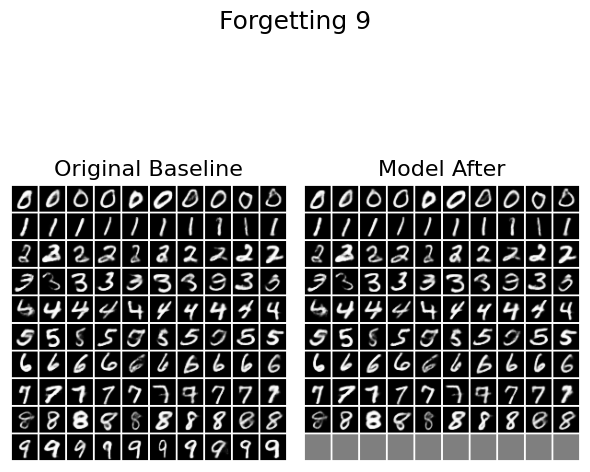

In [ ]:
def comparison_grid(baseline_model_path, unlearned_model_path, title_extra="",
                    rows=10, cols=10, seed=0):

    baseline_model = CVAE().to(DEVICE)
    baseline_model.load_state_dict(torch.load(baseline_model_path))
    unlearned_model = CVAE().to(DEVICE)
    unlearned_model.load_state_dict(torch.load(unlearned_model_path))
    baseline_model.eval()
    unlearned_model.eval()

    labels = []
    for d in range(NUM_CLASSES):
        labels.extend([d] * (rows * cols // NUM_CLASSES))
    labels = labels[: rows * cols]
    if len(labels) < rows * cols:
        labels.extend([labels[-1]] * (rows*cols - len(labels)))

    y = torch.tensor(labels, device=DEVICE)
    g = torch.Generator(device=DEVICE).manual_seed(seed)
    z = torch.randn(len(labels), LATENT_DIM, generator=g, device=DEVICE)

    def decode_grid(model_to_decode):
        with torch.no_grad():
            imgs = model_to_decode.decode(z, F.one_hot(y, NUM_CLASSES).float()).cpu()
        return vutils.make_grid(imgs, nrow=cols, pad_value=1)

    grid_left  = decode_grid(baseline_model)
    grid_right = decode_grid(unlearned_model)

    fig, ax = plt.subplots(1, 2, figsize=(6, 6))
    fig.suptitle(f"Forgetting {title_extra}", fontsize=18)
    for a, grid, title in zip(ax, [grid_left, grid_right],
                              ["Original Baseline", f"Model After"]):
        a.imshow(grid.permute(1, 2, 0), cmap="gray")
        a.set_title(title, fontsize=16)
        a.axis("off")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

baseline_path = CKPT_DIR / "vae_baseline.pt"
unlearned_path = CKPT_DIR / f'vae_forget_{FORGET_CLASS}_ewc_version.pt'

if baseline_path.exists() and unlearned_path.exists():
    comparison_grid(baseline_path, unlearned_path, title_extra=str(FORGET_CLASS))
else:
    if not baseline_path.exists(): print(f" - Missing: {baseline_path}")
    if not unlearned_path.exists(): print(f" - Missing: {unlearned_path}")

compar grid after unlearning 2

Comparing: vae_forget_9_ewc_version.pt (left) vs vae_forget_9_and_2_ewc_version.pt (right)


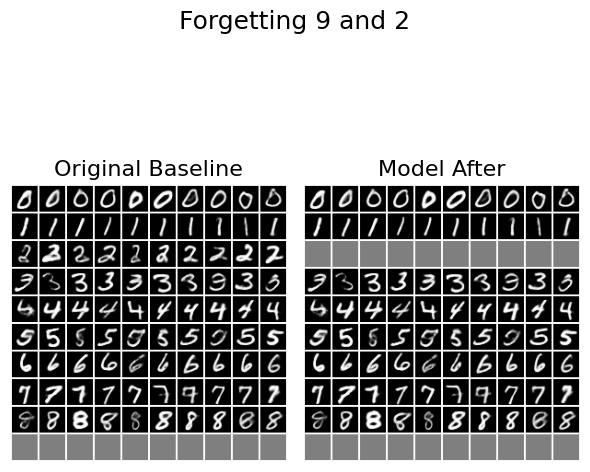

In [ ]:
baseline_path = CKPT_DIR / 'vae_forget_9_ewc_version.pt'

unlearned_path = CKPT_DIR / 'vae_forget_9_and_2_ewc_version.pt'

title = "9 and 2"

if baseline_path.exists() and unlearned_path.exists():
    print(f"Comparing: {baseline_path.name} (left) vs {unlearned_path.name} (right)")
    comparison_grid(baseline_path, unlearned_path, title_extra=title)
else:
    if not baseline_path.exists(): print(f" - Missing: {baseline_path}")
    if not unlearned_path.exists(): print(f" - Missing: {unlearned_path}")

latent space plot

In [ ]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from tqdm.notebook import tqdm

def plot_latent_space(model, dataloader, title="Latent Space", forget_classes=[], num_classes=10):
    model.eval()
    all_mu = []
    all_labels = []

    with torch.no_grad():
        for x, y in tqdm(dataloader, desc="Encoding test set"):
            x = x.to(DEVICE) # Only move x to device

            neutral_y_1h = torch.full(
                (x.size(0), num_classes),
                1.0 / num_classes,
                device=DEVICE
            )

            mu, _ = model.encode(x, neutral_y_1h)

            all_mu.append(mu.cpu())
            all_labels.append(y.cpu())

    all_mu = torch.cat(all_mu).numpy()
    all_labels = torch.cat(all_labels).numpy()

    print("Standardizing latent vectors...")
    all_mu = StandardScaler().fit_transform(all_mu)

    print("Running t-SNE...")
    tsne = TSNE(
        n_components=2,
        perplexity=40,
        n_iter=3000,
        learning_rate=200,
        init='pca',
        random_state=42
    )
    z_2d = tsne.fit_transform(all_mu)
    print("t-SNE complete.")

    # --- Plotting (this part was fine) ---
    plt.figure(figsize=(12, 10))
    palette = sns.color_palette("bright", num_classes)

    # Use seaborn for easier legend handling
    sns.scatterplot(
        x=z_2d[:, 0],
        y=z_2d[:, 1],
        hue=all_labels,
        palette=palette,
        legend="full",
        s=10,
        alpha=0.7
    )

    for c in range(num_classes):
        if c in forget_classes: continue
        m = (all_labels == c)
        if not np.any(m): continue
        cx, cy = z_2d[m, :].mean(axis=0)
        plt.text(cx, cy, str(c), fontsize=14, weight='bold',
                 ha='center', va='center', color='black',
                 bbox=dict(boxstyle='round,pad=0.2', fc='white', ec='none', alpha=0.7))

    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)
    plt.title(title, fontsize=18)
    plt.xlabel("t-SNE Dimension 1", fontsize=12)
    plt.ylabel("t-SNE Dimension 2", fontsize=12)
    plt.tight_layout(rect=[0, 0, 0.88, 1])
    plt.show()

In [ ]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt

def plot_latent_space_tsne(model, dataloader, title="Latent Space",
                           forget_classes=[], num_classes=10, device=DEVICE):
    model.eval()
    all_mu = []
    all_labels = []

    with torch.no_grad():
        for x, y in tqdm(dataloader, desc="..."):
            x = x.to(device)

            neutral_y_1h = torch.full(
                (x.size(0), num_classes),
                1.0 / num_classes,
                device=device
            )

            mu, _ = model.encode(x, neutral_y_1h)


            all_mu.append(mu.cpu())
            all_labels.append(y.cpu())

    all_mu = torch.cat(all_mu).numpy()
    all_labels = torch.cat(all_labels).numpy()

    all_mu = StandardScaler().fit_transform(all_mu)

    tsne = TSNE(
        n_components=2,
        perplexity=40,
        n_iter=3000,
        learning_rate=200,
        init='pca',
        random_state=42
    )
    z_2d = tsne.fit_transform(all_mu)

    plt.figure(figsize=(10, 8))
    palette = sns.color_palette("bright", num_classes)

    sns.scatterplot(
        x=z_2d[:, 0],
        y=z_2d[:, 1],
        hue=all_labels,
        palette=palette,
        legend="full",
        s=10,
        alpha=0.7
    )

    for c in range(num_classes):
        if c in forget_classes: continue
        m = (all_labels == c)
        if not np.any(m): continue
        cx, cy = z_2d[m, :].mean(axis=0)
        plt.text(cx, cy, str(c), fontsize=14, weight='bold',
                 ha='center', va='center', color='black',
                 bbox=dict(boxstyle='round,pad=0.2', fc='white', ec='none', alpha=0.7))

    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)
    plt.title(title, fontsize=18)
    plt.xlabel("t-SNE Dimension 1", fontsize=12)
    plt.ylabel("t-SNE Dimension 2", fontsize=12)
    plt.tight_layout(rect=[0, 0, 0.88, 1])
    plt.show()

...:   0%|          | 0/79 [00:00<?, ?it/s]

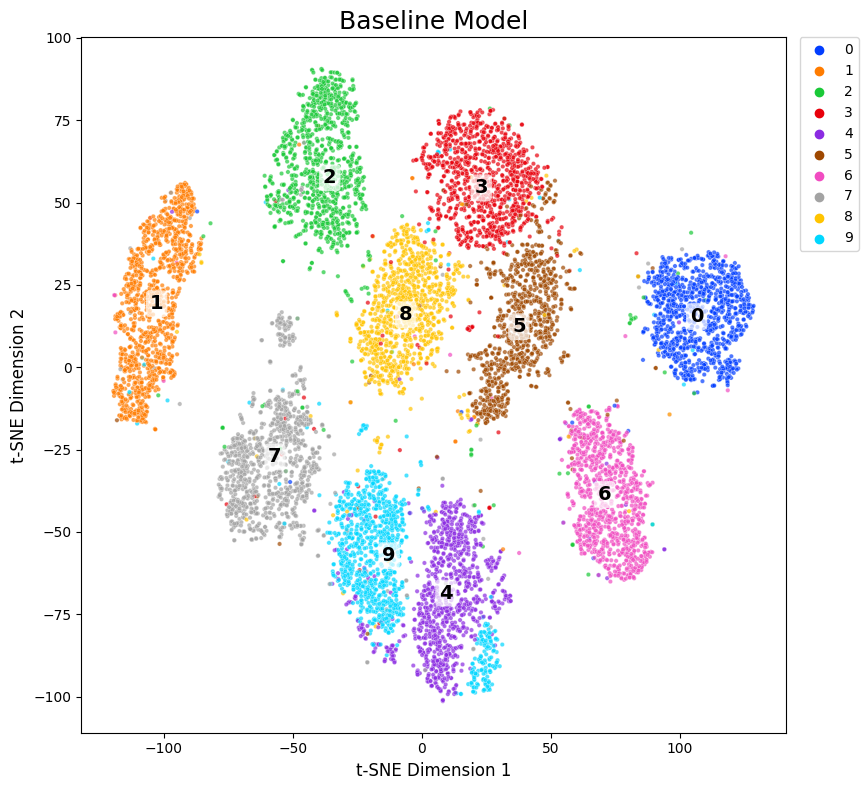

...:   0%|          | 0/79 [00:00<?, ?it/s]

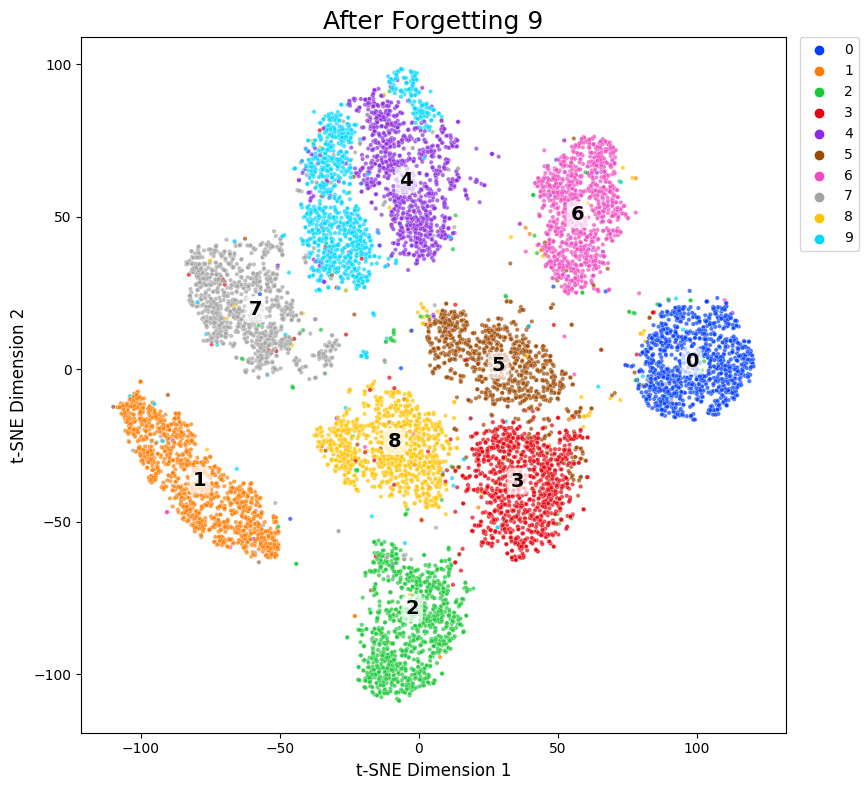

In [ ]:
baseline_model = CVAE().to(DEVICE)
baseline_model.load_state_dict(torch.load(CKPT_DIR / "vae_baseline.pt"))
baseline_model.eval()

unlearned_model_path = CKPT_DIR / f'vae_forget_{FORGET_CLASS}_ewc_version.pt'
unlearned_model = CVAE().to(DEVICE)
unlearned_model.load_state_dict(torch.load(unlearned_model_path))
unlearned_model.eval()


plot_latent_space_tsne(baseline_model, test_ld, title="Baseline Model")
plot_latent_space_tsne(unlearned_model, test_ld,
                       title=f"After Forgetting {FORGET_CLASS}",
                       forget_classes=[FORGET_CLASS])

latent space after unlearning 2

...:   0%|          | 0/79 [00:00<?, ?it/s]

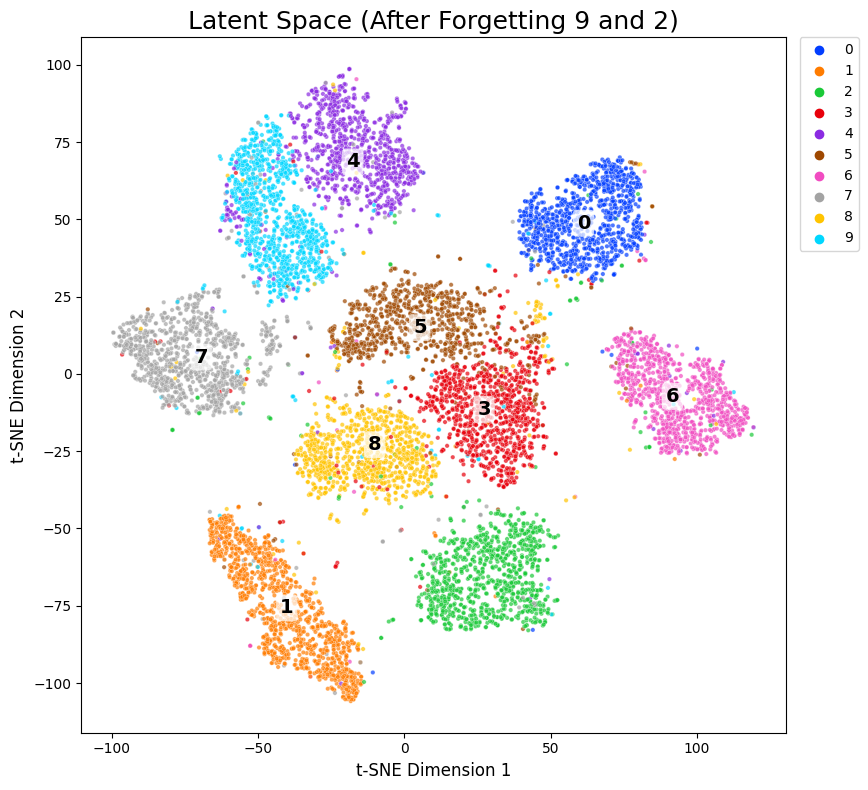

In [ ]:
model_forgot_both_path = CKPT_DIR / 'vae_forget_9_and_2_ewc_version.pt'

if not model_forgot_both_path.exists():
    print(f"Error: {model_forgot_both_path.name} not found!")
else:
    model_forgot_both = CVAE().to(DEVICE)
    model_forgot_both.load_state_dict(torch.load(model_forgot_both_path))
    model_forgot_both.eval()


    plot_latent_space_tsne(
        model_forgot_both,
        test_ld,
        title="Latent Space (After Forgetting 9 and 2)",
        forget_classes=[9, 2],
        num_classes=NUM_CLASSES
    )

manifold grids

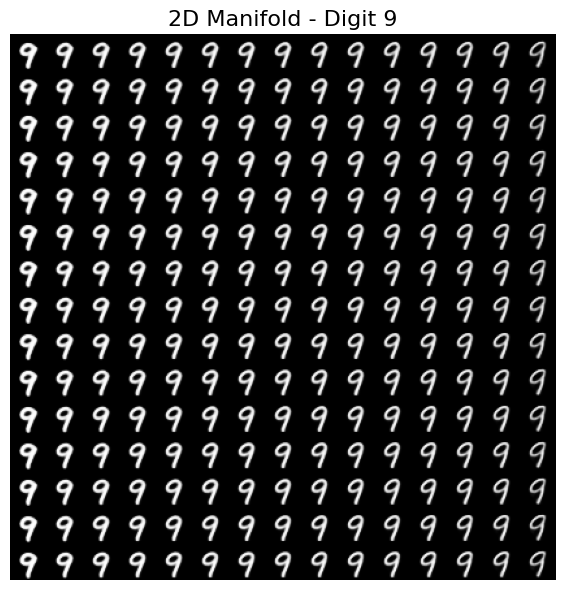

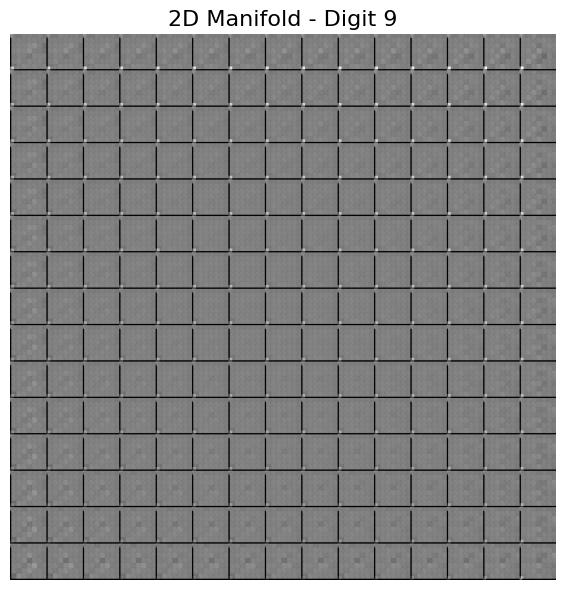

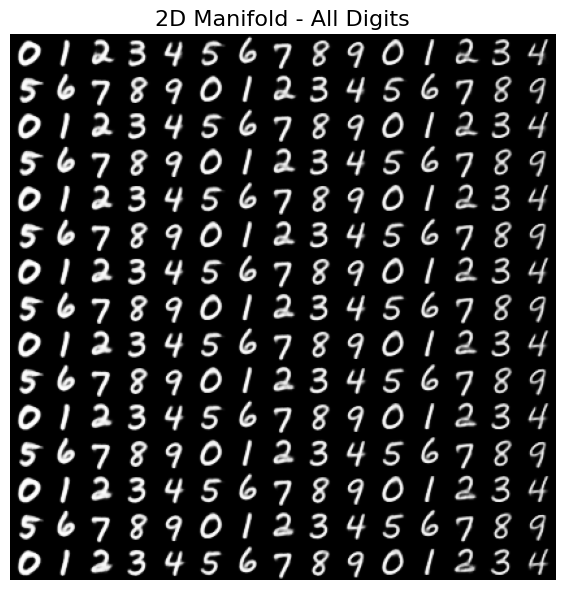

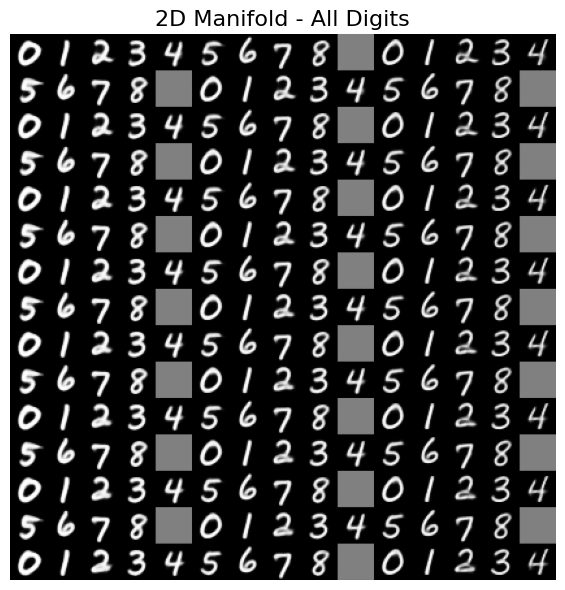

In [ ]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
def plot_2d_manifold(model, digit=None, n=15, figsize=6):
    model.eval()
    digit_size = 28

    z1 = norm.ppf(np.linspace(0.01, 0.99, n))
    z2 = norm.ppf(np.linspace(0.01, 0.99, n))

    z_grid = np.dstack(np.meshgrid(z1, z2))
    z_flat = z_grid.reshape(n*n, 2)

    z_full = np.zeros((n*n, LATENT_DIM))
    z_full[:, 0] = z_flat[:, 0]
    z_full[:, 1] = z_flat[:, 1]

    z_tensor = torch.from_numpy(z_full).float().to(DEVICE)

    if digit is not None:
        y = torch.full((n*n,), digit, device=DEVICE)
        y_onehot = F.one_hot(y, NUM_CLASSES).float()
    else:
        y = torch.tensor([i % NUM_CLASSES for i in range(n*n)], device=DEVICE)
        y_onehot = F.one_hot(y, NUM_CLASSES).float()
    with torch.no_grad():
        images = model.decode(z_tensor, y_onehot).cpu()

    images_grid = images.reshape(n, n, 1, digit_size, digit_size)

    block = []
    for i in range(n):
        row = []
        for j in range(n):
            row.append(images_grid[i, j, 0].numpy())
        block.append(row)

    plt.figure(figsize=(figsize, figsize))
    plt.imshow(np.block(block), cmap='gray')
    plt.axis('off')

    if digit is not None:
        plt.title(f'2D Manifold - Digit {digit}', fontsize=16)
    else:
        plt.title('2D Manifold - All Digits', fontsize=16)

    plt.tight_layout()
    plt.show()


plot_2d_manifold(baseline_model, digit=FORGET_CLASS, n=15)

plot_2d_manifold(unlearned_model, digit=FORGET_CLASS, n=15)

plot_2d_manifold(baseline_model, digit=None, n=15)

plot_2d_manifold(unlearned_model, digit=None, n=15)

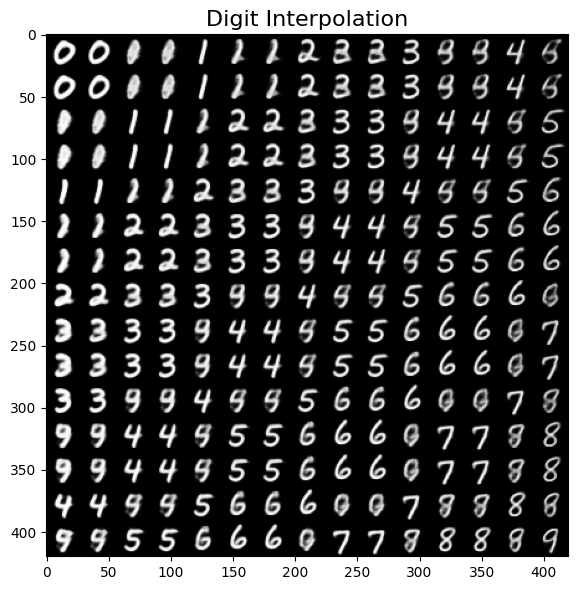

In [ ]:
def smooth_transition(model, n=15, digit_size=28):
    model.eval()

    z1 = norm.ppf(np.linspace(0.01, 0.99, n))
    z2 = norm.ppf(np.linspace(0.01, 0.99, n))
    z_grid = np.dstack(np.meshgrid(z1, z2))

    z_flat = z_grid.reshape(n*n, 2)
    z_full = np.zeros((n*n, LATENT_DIM))
    z_full[:, 0] = z_flat[:, 0]
    z_full[:, 1] = z_flat[:, 1]

    z_tensor = torch.from_numpy(z_full).float().to(DEVICE)

    labels_soft = np.zeros((n*n, NUM_CLASSES))

    for i in range(n):
        for j in range(n):
            idx = i * n + j

            row_weight = i / (n-1)
            col_weight = j / (n-1)

            target_digit1 = int(row_weight * (NUM_CLASSES - 1))
            target_digit2 = int(col_weight * (NUM_CLASSES - 1))

            avg_digit = (target_digit1 + target_digit2) / 2
            main_digit = int(avg_digit)
            next_digit = (main_digit + 1) % NUM_CLASSES

            blend_weight = avg_digit - main_digit

            labels_soft[idx, main_digit] = 1 - blend_weight
            if blend_weight > 0:
                labels_soft[idx, next_digit] = blend_weight
            else:
                labels_soft[idx, main_digit] = 1.0

    y_onehot = torch.from_numpy(labels_soft).float().to(DEVICE)

    with torch.no_grad():
        x_decoded = model.decode(z_tensor, y_onehot).cpu().numpy()

    x_decoded = x_decoded.reshape(n, n, digit_size, digit_size)
    image_block = np.block(list(map(list, x_decoded)))

    plt.figure(figsize=(6, 6))
    plt.imshow(image_block, cmap='gray')
    plt.axis('on')
    plt.title('Digit Interpolation', fontsize=16)
    plt.tight_layout()
    plt.show()

smooth_transition(baseline_model)

Generative Attack (Prototype Matching)

Restarts:   0%|          | 0/6 [00:00<?, ?it/s]

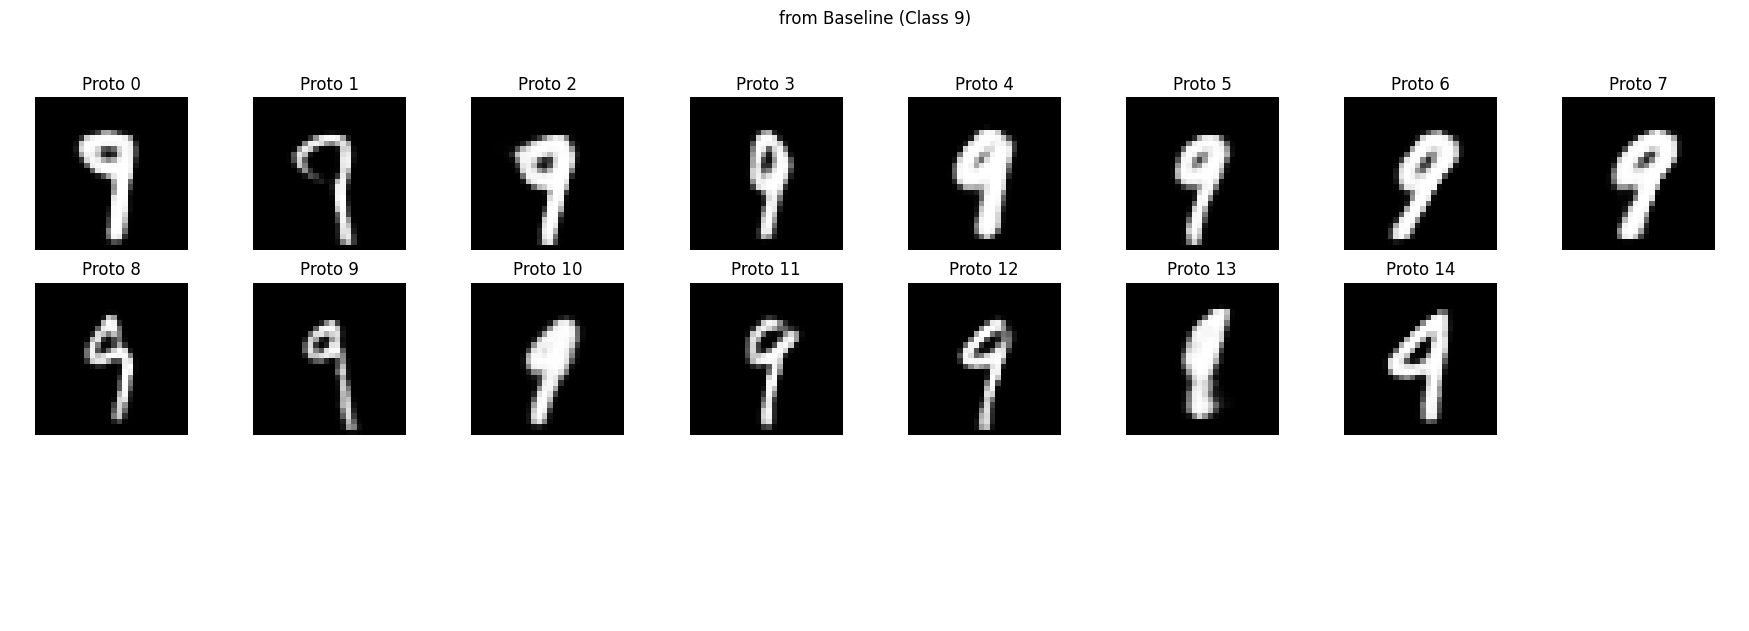

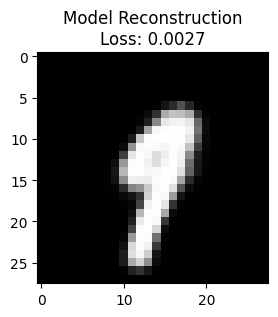

NameError: name 'make_grid' is not defined. Make sure.


In [ ]:
if 'FORGET_CLASS' not in globals() or 'CKPT_DIR' not in globals() or 'DEVICE' not in globals() or 'LATENT_DIM' not in globals() or 'NUM_CLASSES' not in globals():
    print("ERROR")
else:
    try:
        baseline_model_path = CKPT_DIR / "vae_baseline.pt"
        baseline   = CVAE().to(DEVICE)
        baseline.load_state_dict(torch.load(baseline_model_path))

        forget_string_current = f"{FORGET_CLASS}_ewc_version"
        unlearned_model_path = CKPT_DIR / f"vae_forget_{forget_string_current}.pt"

        unlearned  = CVAE().to(DEVICE)
        unlearned.load_state_dict(torch.load(unlearned_model_path))
        baseline.eval(); unlearned.eval()

        for p in list(baseline.parameters()) + list(unlearned.parameters()):
            p.requires_grad_(False)

        def tv_loss(x):
            dh = (x[:, :, :, 1:] - x[:, :, :, :-1]).abs().mean()
            dv = (x[:, :, 1:, :] - x[:, :, :-1, :]).abs().mean()
            return dh + dv

        K_PROTOS = 15
        POOL = 512
        targets = None
        with torch.no_grad():
            z_pool = torch.randn(POOL, LATENT_DIM, device=DEVICE)
            y_forget_onehot = F.one_hot(torch.full((POOL,), FORGET_CLASS, device=DEVICE), NUM_CLASSES).float()
            imgs_pool = baseline.decode(z_pool, y_forget_onehot)

            sharpness = ((imgs_pool - 0.5)**2).mean(dim=(1,2,3))
            topk = torch.topk(sharpness, K_PROTOS).indices
            targets = imgs_pool[topk].detach()

        N_RESTARTS = 6
        STEPS = 800
        LR_Z = 0.06
        LR_Y = 0.1
        ALPHA_TV = 0.02
        L2Z = 1e-3

        best_loss, best_img, best_y, best_z = float('inf'), None, None, None

        for r in tqdm(range(N_RESTARTS), desc="Restarts"):
            z = torch.randn(1, LATENT_DIM, device=DEVICE, requires_grad=True)
            y_logits = torch.zeros(1, NUM_CLASSES, device=DEVICE, requires_grad=True)
            y_logits.data[:, FORGET_CLASS] = 3.0

            opt = torch.optim.Adam([{'params':[z], 'lr':LR_Z},
                                    {'params':[y_logits], 'lr':LR_Y}])

            for t in range(STEPS):
                opt.zero_grad()
                y_soft = F.softmax(y_logits, dim=1)
                out = unlearned.decode(z, y_soft)

                mse_list = ((out.expand_as(targets) - targets)**2).mean(dim=(1,2,3))
                mse = torch.min(mse_list)

                loss = mse + ALPHA_TV*tv_loss(out) + L2Z*(z**2).mean()

                loss.backward()
                opt.step()

                with torch.no_grad():
                    z.data.clamp_(-4, 4)

            if loss.item() < best_loss:
                best_loss = loss.item()
                best_img = out.detach()
                best_y = F.softmax(y_logits.detach(), dim=1)
                best_z = z.detach()

        def _to_mpl_img(t):
            t = t.detach().cpu()
            if t.dim() == 4: t = t[0]
            if t.dim() == 3 and t.size(0) == 1: t = t.squeeze(0)
            if t.dim() == 3: t = t.permute(1, 2, 0)
            return t.clamp(0, 1)

        rows = 3
        cols = K_PROTOS // 2 if K_PROTOS % 2 == 0 else (K_PROTOS // 2 + 1)
        fig, axes = plt.subplots(rows, cols, figsize=(2.2*cols, 2.2*rows))
        axes = axes.flatten()
        for i in range(K_PROTOS):
            axes[i].imshow(_to_mpl_img(targets[i]), cmap="gray")
            axes[i].set_title(f"Proto {i}")
            axes[i].axis("off")
        for j in range(K_PROTOS, len(axes)): axes[j].axis("off") # Hide unused axes
        plt.suptitle(f"from Baseline (Class {FORGET_CLASS})")
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

        plt.figure(figsize=(3,3))
        plt.imshow(_to_mpl_img(best_img), cmap="gray")
        plt.title(f"Model Reconstruction\nLoss: {best_loss:.4f}"); plt.axis("on")
        plt.show()

        with torch.no_grad():
            eps = 0.25
            zs = torch.stack([best_z + dx for dx in [
                torch.zeros_like(best_z), *(torch.randn_like(best_z)*eps for _ in range(7))
            ]], dim=0).squeeze(1)
            ys = best_y.repeat(zs.size(0), 1)
            outs = unlearned.decode(zs, ys).cpu()

        grid = make_grid(outs, nrow=4, pad_value=1.0)
        plt.figure(figsize=(6,6))
        plt.imshow(_to_mpl_img(grid), cmap="gray")
        plt.axis("off"); plt.title(f"around z* (Class {FORGET_CLASS})")
        plt.show()

    except NameError as e:
        print(f"NameError: {e}. Make sure.")
    except FileNotFoundError as e:
        print(f"FileNotFoundError: {e}filenames.")
    except Exception as e:
        print(f"unexpected {e}")

 Attack: Classifier-Guided Input Optimization

Unlearned CVAE (target) loaded from: vae_forget_9_ewc_version.pt


Attack Restarts:   0%|          | 0/6 [00:00<?, ?it/s]

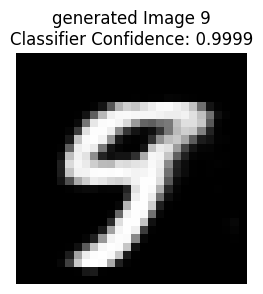

In [ ]:
if 'FORGET_CLASS' not in globals() or 'CKPT_DIR' not in globals() or 'DEVICE' not in globals() or 'NUM_CLASSES' not in globals():
    print("ERROR:")
else:
    CLASSIFIER_PATH = CKPT_DIR / "classifier.pt"

    class SimpleClassifier(nn.Module):
        def __init__(self):
            super().__init__()
            self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
            self.bn1 = nn.BatchNorm2d(10)
            self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
            self.bn2 = nn.BatchNorm2d(20)
            self.conv2_drop = nn.Dropout2d()
            self.fc1 = nn.Linear(320, 50)
            self.fc2 = nn.Linear(50, NUM_CLASSES)

        def forward(self, x):
            x = F.relu(F.max_pool2d(self.bn1(self.conv1(x)), 2))
            x = F.relu(F.max_pool2d(self.conv2_drop(self.bn2(self.conv2(x))), 2))
            x = x.view(-1, 320)
            x = F.relu(self.fc1(x))
            x = F.dropout(x, training=self.training)
            x = self.fc2(x)
            return F.log_softmax(x, dim=1)

    if not CLASSIFIER_PATH.exists():
        print("Training classifier...")
        clf_model = SimpleClassifier().to(DEVICE)
        clf_optim = torch.optim.Adam(clf_model.parameters(), lr=1e-3)
        clf_epochs = 5
        clf_train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=N_WORKERS)
        for epoch in range(1, clf_epochs + 1):
            clf_model.train()
            pbar_clf = tqdm(clf_train_loader, desc=f"Training Clf Epoch {epoch}/{clf_epochs}", leave=False)
            for data, target in pbar_clf:
                data, target = data.to(DEVICE), target.to(DEVICE)
                clf_optim.zero_grad()
                output = clf_model(data)
                loss = F.nll_loss(output, target)
                loss.backward()
                clf_optim.step()
        torch.save(clf_model.state_dict(), CLASSIFIER_PATH)


    try:

        classifier = SimpleClassifier().to(DEVICE)
        classifier.load_state_dict(torch.load(CLASSIFIER_PATH))
        classifier.eval()
        for p in classifier.parameters():
            p.requires_grad_(False)


        unlearned_model_path = CKPT_DIR / f"vae_forget_{FORGET_CLASS}_ewc_version.pt"
        unlearned = CVAE().to(DEVICE)
        unlearned.load_state_dict(torch.load(unlearned_model_path))
        unlearned.eval()
        for p in unlearned.parameters():
            p.requires_grad_(False)
        print(f"Unlearned CVAE (target) loaded from: {unlearned_model_path.name}")



        TARGET_CLASS = FORGET_CLASS
        N_RESTARTS = 6

        STEPS = 2000

        LR_Z = 0.05
        LR_Y = 0.1
        ALPHA_TV = 0.01
        L2Z = 1e-3

        best_loss, best_img = float('inf'), None

        for r in tqdm(range(N_RESTARTS), desc="Attack Restarts"):
            z = torch.randn(1, LATENT_DIM, device=DEVICE, requires_grad=True)
            y_logits = torch.zeros(1, NUM_CLASSES, device=DEVICE, requires_grad=True)
            y_logits.data[:, TARGET_CLASS] = 3.0

            opt = torch.optim.Adam([{'params':[z], 'lr':LR_Z},
                                    {'params':[y_logits], 'lr':LR_Y}])

            def tv_loss(x):
                dh = (x[:, :, :, 1:] - x[:, :, :, :-1]).abs().mean()
                dv = (x[:, :, 1:, :] - x[:, :, :-1, :]).abs().mean()
                return dh + dv

            for t in range(STEPS):
                opt.zero_grad()

                y_soft = F.softmax(y_logits, dim=1)

                out_img = unlearned.decode(z, y_soft)

                log_probs = classifier(out_img)


                loss = -log_probs[0, TARGET_CLASS] * 10.0

                loss += ALPHA_TV * tv_loss(out_img) + L2Z * (z**2).mean()

                loss.backward()
                opt.step()

                with torch.no_grad():
                    z.data.clamp_(-4, 4)

            if loss.item() < best_loss:
                best_loss = loss.item()
                best_img = out_img.detach()

        final_optimized_image = best_img.cpu().squeeze()
        with torch.no_grad():
            final_log_probs = classifier(best_img)
            final_prob = final_log_probs.exp()[0, TARGET_CLASS].item()

        plt.figure(figsize=(3, 3))
        plt.imshow(final_optimized_image, cmap='gray')
        plt.title(f"generated Image {TARGET_CLASS}\nClassifier Confidence: {final_prob:.4f}")
        plt.axis('off')
        plt.show()

    except FileNotFoundError as e:
        print(f"ERROR")
    except Exception as e:
        print(f"unexpected")